# Segmentation 모델 구현

<br>

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; 본문
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 심층 신경망 네트워크의 성능은 데이터량에 비례합니다. 그러나 데이터셋 구축 과정에서 데이터 수집-레이블링에 많은 자원이 요구됩니다. 이에 한정된 데이터셋을 이용하여 새로운 데이터를 생성하는 다양한 데이터 증강 기법이 제시되었습니다. 윤상두 외 5인은 데이터에서 특정 영역을 자르고 해당 영역을 다른 데이터로 채우는 방식의 새로운 Mixup의 변형인 증강 기법을 제시하였습니다[1]. 본 프로젝트에서는 앞선 증강 기법의 성능을 확인하고자 합니다. 비교를 위해 좌우 대칭 회전, 밝기 변화를 수행하는 기본 증강 데이터셋, Mixup 데이터셋, Cutmix 데이터셋을 사용합니다. 성능 비교를 위해 사용하는 데이터셋은, Tensorflow에서 제공하는 'stanford_dogs'입니다.
</span><br><br>

> _1. 데이터 분석_
>
> _2. 데이터 전처리 및 데이터 증강_
>
> _3. 모델 생성_
>
> _4. 모델 학습 및 평가_

<br><br>

_**<span style="color:red">※본 예제는 LMS 클라우드가 아닌 로컬에서 진행되어 학습 속도 및 결과 등이 상이할 수 있습니다.</span>**_
***

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리를 호출합니다.
***

In [1]:
import os, math
import numpy as np
from glob import glob

from PIL import Image
from skimage.io import imread
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as K
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model, Input
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델을 생성하고 학습하기 이전에 주어진 데이터를 분석하고자 합니다. 데이터 분석을 통해 데이터의 특성을 알고 이를 통해 데이터를 적절하게 정제하거나 알맞은 모델을 설계할 수 있습니다. 따라서 우선적으로 주어진 데이터셋의 기본적인 정보부터 구체적인 특징까지 파악한 이후 프로젝트를 진행할 필요가 있습니다.
</span><br><br>
    
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서 사용하는 데이터는 Tensorflow에서 제공하는 120 품종의 개 이미지 - 레이블 쌍으로 이루어진 'stanford_dogs' 데이터셋 입니다. 학습 데이터 12,000개, 테스트 데이터 8,580개입니다. 분석 결과 입력 데이터는 0에서 255 사이의 int8 형식의 이미지 이며, 각 이미지의 크기가 상이하였습니다.
</span>
***

In [2]:
def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop( 
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(width=224, height=224)
        ])
    return Compose([Resize(width=224,height=224)])

<br>

#### 데이터셋 불러오기
***
+ 예제에 사용되는 학습 데이터를 불러온다.


+ Tensorflow에서 제공하는 120종의 개 이미지로 이루어진 `stanford_dogs` 데이터셋을 사용한다.
***

<br>

#### 데이터셋 샘플 시각화
***
+ 데이터셋 이미지를 시각화 한다.


+ 각 이미지의 사이즈가 상이한 것을 확인할 수 있다.


+ 품종 명과 그에 해당하는 클래스 번호를 확인할 수 있다.
***

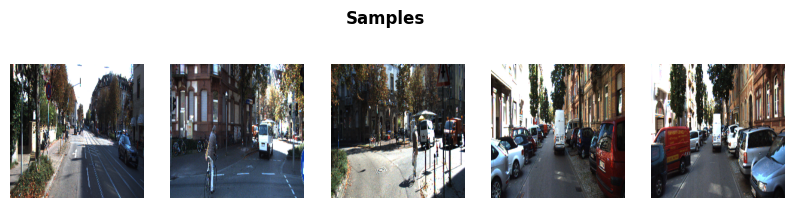

In [3]:
sample_nums = 5
dir_path = '../datasets/gd_08/dataset/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(10, 2.5))
plt.suptitle('Samples', fontsize=12, fontweight='bold')
for idx in range(1, sample_nums+1):
    image = imread(input_images[idx])
    image_data = {'image': image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)

    plt.subplot(1, sample_nums, idx)
    plt.axis('off')
    plt.imshow(resized['image'])

plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
        dir_path,
        batch_size=4,
        img_size=(224, 224, 3),
        output_size=(224, 224),
        is_train=True,
        augmentation=None
    ):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path, augmentation=augmentation)
test_generator = KittiGenerator(dir_path, augmentation=test_preproc, is_train=False)

<br>

## 3. 모델 구현 및 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 네트워크 학습 전, 데이터셋을 네트워크에 입력 가능한 크기로 변경하거나 학습 효율을 위해 데이터셋을 가공하는 데이터 전처리를 수행합니다. 'stanford_dogs' 데이터셋의 경우, 입력 데이터인 이미지의 크기가 상이하기 때문에, 모든 이미지 크기를 224 × 224로 리사이즈 해주었습니다. 또한 학습 효율을 위해 모든 이미지에 대해 Min-Max 정규화를 수행하였습니다.
</span>

<br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트에서는 'Cutmix'의 성능을 확인하기 위해, 원본 데이터셋(1), 기본 증강 데이터셋(2), Mixup 데이터셋(3), Cutmix 데이터셋(4)의 테스트 셋에 대한 손실 값을 비교합니다. 기본 증강의 경우 좌우 대칭 회전 및 밝기 변화를 수행하였습니다. Mixup과 Cutmix 모두 α 값을 1.0으로 설정하였습니다.
</span>

***

In [6]:
class ConvBlock(layers.Layer):
    def __init__(self, input_size: int):
        conv_info = {'activation': 'relu', 'padding': 'same', 'kernel_initializer': 'he_normal'}
        super(ConvBlock, self).__init__()
        
        self.convs = [layers.Conv2D(input_size, kernel_size=3, **conv_info) for _ in range(2)]
        self.batchNorm = layers.BatchNormalization()
        
    def call(self, x):
        out = x
        for conv in self.convs:
            out = conv(out)
        out = self.batchNorm(out)
        return out
    
    
class ConvTBlock(layers.Layer):
    def __init__(self, input_size: int):
        conv_info = {'strides': (2, 2), 'activation': 'relu', 'kernel_initializer': 'he_normal'}
        super(ConvTBlock, self).__init__()        
        
        self.convT = layers.Conv2DTranspose(filters=input_size, kernel_size=2, **conv_info)

    def call(self, x):
        return self.convT(x)
    

class EncBlock(layers.Layer):
    def __init__(self, input_size: int, is_maxpool: bool=True):
        super(EncBlock, self).__init__()
        self.maxpool = None
        if is_maxpool:
            self.maxpool = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv_block = ConvBlock(input_size)
        
    def call(self, x):
        out = x
        if self.maxpool is not None:
            out = self.maxpool(out)
        out = self.conv_block(out)
        return out
    

class DecBlock(layers.Layer):
    def __init__(self, input_size: int):
        super(DecBlock, self).__init__()
        self.upsample = ConvTBlock(input_size)
        self.conv_block = ConvBlock(input_size)
        
        
    def call(self, dec_x, *enc_x):
        dec_x = self.upsample(dec_x)

        out = layers.concatenate([dec_x, *enc_x], axis=3)
        out = self.conv_block(out)
        return out
    
    
class UnetBottleNeck(layers.Layer):
    def __init__(self, input_size: int):
        super(UnetBottleNeck, self).__init__()
        self.conv = ConvBlock(input_size=input_size)
        
    def call(self, x):
        out = x
        enc_out = layers.Dropout(0.5)(out)
        out = layers.MaxPooling2D(pool_size=(2, 2))(enc_out)
        out = self.conv(out)
        dec_out = layers.Dropout(0.5)(out)
        return enc_out, dec_out

<br>

### 3.1. U Net 구현 및 학습

***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 네트워크 학습 전, 데이터셋을 네트워크에 입력 가능한 크기로 변경하거나 학습 효율을 위해 데이터셋을 가공하는 데이터 전처리를 수행합니다. 'stanford_dogs' 데이터셋의 경우, 입력 데이터인 이미지의 크기가 상이하기 때문에, 모든 이미지 크기를 224 × 224로 리사이즈 해주었습니다. 또한 학습 효율을 위해 모든 이미지에 대해 Min-Max 정규화를 수행하였습니다.
</span>

<br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트에서는 'Cutmix'의 성능을 확인하기 위해, 원본 데이터셋(1), 기본 증강 데이터셋(2), Mixup 데이터셋(3), Cutmix 데이터셋(4)의 테스트 셋에 대한 손실 값을 비교합니다. 기본 증강의 경우 좌우 대칭 회전 및 밝기 변화를 수행하였습니다. Mixup과 Cutmix 모두 α 값을 1.0으로 설정하였습니다.
</span>

***

In [7]:
class Unet(Model):
    def __init__(self):
        super(Unet, self).__init__()
        
        enc_filters = [64, 128, 256, 512]
        dec_filters = [512, 256, 128, 64]
        
        self.enc_layers = self.__get_ED_layers(filters=enc_filters, block='enc')
        self.bottle_layer = UnetBottleNeck(input_size=1024)
        self.dec_layers = self.__get_ED_layers(filters=dec_filters, block='dec')
        
        self.last_conv1 = layers.Conv2D(
            filters=2, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'
        )
        self.last_conv2 = layers.Conv2D(
            filters=1, kernel_size=1, activation='sigmoid'
        )
        
    def call(self, x):
        out = x
        enc_outs = []
        for idx, layer in enumerate(self.enc_layers):
            out = layer(out)
            if idx < (len(self.enc_layers)-1):
                enc_outs.append(out)

        enc_out, dec_out = self.bottle_layer(out)
        enc_outs.append(enc_out)
        
        for dec_layer, enc_out in zip(self.dec_layers, enc_outs[::-1]):
            dec_out = dec_layer(dec_out, enc_out)

        out = self.last_conv1(dec_out)
        out = self.last_conv2(out)
        return out
    
    def __get_ED_layers(self, filters: list, block: str):
        if block == 'enc':
            layers = [EncBlock(filters[0], False)]
            for size in filters[1:]:
                layers.append(EncBlock(size, True))
            return layers
        
        elif block == 'dec':
            return [DecBlock(size) for size in filters]
        
        print('Default')
        return [DecBlock(size) for size in filters]
    
    def get_summary(self, input_shape=(224, 224, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [8]:
u_model = Unet()

u_model.compile(optimizer=K.optimizers.Adam(lr=1e-4), loss='binary_crossentropy')
u_his = u_model.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

Y:\programFiles\anaconda3\envs\aiffel\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Y:\programFiles\anaconda3\envs\aiffel\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 7s 78ms/step - loss: 0.2768 - val_loss: 0.4895
Epoch 2/100
43/43 [==============================] - 3s 68ms/step - loss: 0.1869 - val_loss: 0.6488
Epoch 3/100
43/43 [==============================] - 3s 67ms/step - loss: 0.1540 - val_loss: 0.5899
Epoch 4/100
43/43 [==============================] - 3s 67ms/step - loss: 0.1353 - val_loss: 0.5559
Epoch 5/100
43/43 [==============================] - 3s 67ms/step - loss: 0.1123 - val_loss: 0.4617
Epoch 6/100
43/43 [==============================] - 3s 68ms/step - loss: 0.0963 - val_loss: 0.4718
Epoch 7/100
43/43 [==============================] - 3s 69ms/step - loss: 0.0877 - val_loss: 0.1097
Epoch 8/100
43/43 [==============================] - 3s 68ms/step - loss: 0.0812 - val_loss: 0.1546
Epoch 9/100
43/43 [==============================] - 3s 69ms/step - loss: 0.0816 - val_loss: 0.1133
Epoch 10/100
43/43 [==============================] - 3s 68ms/step - loss: 0.0746 - val_loss: 0.0903

43/43 [==============================] - 3s 70ms/step - loss: 0.0517 - val_loss: 0.0762
Epoch 83/100
43/43 [==============================] - 3s 70ms/step - loss: 0.0525 - val_loss: 0.0842
Epoch 84/100
43/43 [==============================] - 3s 70ms/step - loss: 0.0545 - val_loss: 0.0607
Epoch 85/100
43/43 [==============================] - 3s 70ms/step - loss: 0.0535 - val_loss: 0.0631
Epoch 86/100
43/43 [==============================] - 3s 70ms/step - loss: 0.0515 - val_loss: 0.0656
Epoch 87/100
43/43 [==============================] - 3s 71ms/step - loss: 0.0502 - val_loss: 0.0767
Epoch 88/100
43/43 [==============================] - 3s 71ms/step - loss: 0.0515 - val_loss: 0.0663
Epoch 89/100
43/43 [==============================] - 3s 71ms/step - loss: 0.0507 - val_loss: 0.0659
Epoch 90/100
43/43 [==============================] - 3s 70ms/step - loss: 0.0547 - val_loss: 0.0715
Epoch 91/100
43/43 [==============================] - 3s 70ms/step - loss: 0.0500 - val_loss: 0.0843
Epo

<br>

### 3.2. U Net++ 구현 및 학습

***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 네트워크 학습 전, 데이터셋을 네트워크에 입력 가능한 크기로 변경하거나 학습 효율을 위해 데이터셋을 가공하는 데이터 전처리를 수행합니다. 'stanford_dogs' 데이터셋의 경우, 입력 데이터인 이미지의 크기가 상이하기 때문에, 모든 이미지 크기를 224 × 224로 리사이즈 해주었습니다. 또한 학습 효율을 위해 모든 이미지에 대해 Min-Max 정규화를 수행하였습니다.
</span>

<br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트에서는 'Cutmix'의 성능을 확인하기 위해, 원본 데이터셋(1), 기본 증강 데이터셋(2), Mixup 데이터셋(3), Cutmix 데이터셋(4)의 테스트 셋에 대한 손실 값을 비교합니다. 기본 증강의 경우 좌우 대칭 회전 및 밝기 변화를 수행하였습니다. Mixup과 Cutmix 모두 α 값을 1.0으로 설정하였습니다.
</span>

***

In [9]:
class UppNet(Model):
    def __init__(self):
        super(UppNet, self).__init__()
        enc_filters = [64, 128, 256, 512]
        dec_filters = [512, 256, 128, 64]
        
        self.enc_layers = self.__get_ED_layers(filters=enc_filters, block='enc')
        self.bottle_layer = UnetBottleNeck(input_size=1024)
        self.dec_layers = self.__get_ED_layers(filters=dec_filters, block='dec')
        self.last_conv = layers.Conv2D(1, 1, activation='sigmoid')
        
    def call(self, x):
        out = x
        enc_outs = []
        for idx, layer in enumerate(self.enc_layers):
            out = layer(out)
            if idx < (len(self.enc_layers)-1):
                enc_outs.append(out)

        enc_out, dec_out = self.bottle_layer(out)
        
        
        #Decoder Flow==============================
        enc_outs.extend([enc_out, dec_out])
        
        dec_buff = list()
        enc_li = len(enc_outs) - 1 #enc last idx
        
        for d_i, deep in enumerate(self.dec_layers):
            li = enc_li - d_i #last index
            dec_x, enc_x = enc_outs[li], enc_outs[li-1]
            
            enc_buff = list()
            for w_i, wide in enumerate(deep):
                if w_i == 0:
                    out_d_w = wide(dec_x, enc_x)
                else:
                    out_dP1_w = dec_buff.pop(0)

                    out_d_w = wide(out_dP1_w, enc_x, *enc_buff)

                dec_buff.append(out_d_w)
                enc_buff.append(out_d_w)
        #End=========================================
        
        out = self.last_conv(out_d_w)
        return out

        
    def __get_ED_layers(self, filters: list, block: str):
        layers = []
        if block == 'enc':
            layers = [EncBlock(filters[0], False)]
            for size in filters[1:]:
                layers.append(EncBlock(size, True))
            return layers

        for deep, size in enumerate(filters):
            layers.append(tuple(DecBlock(size) for wide in range(deep+1)))
        return layers
        
        print('Default')
        return layers
    
    def get_summary(self, input_shape=(224, 224, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
upp_model = UppNet()


upp_model.compile(optimizer=K.optimizers.Adam(lr=1e-4), loss='binary_crossentropy')
upp_his = upp_model.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

Epoch 1/100
43/43 [==============================] - 13s 181ms/step - loss: 0.6723 - val_loss: 0.6148
Epoch 2/100
43/43 [==============================] - 7s 169ms/step - loss: 0.5566 - val_loss: 0.4854
Epoch 3/100
43/43 [==============================] - 7s 167ms/step - loss: 0.4647 - val_loss: 0.2869
Epoch 4/100
43/43 [==============================] - 7s 170ms/step - loss: 0.4405 - val_loss: 0.2245
Epoch 5/100
43/43 [==============================] - 7s 170ms/step - loss: 0.3667 - val_loss: 0.1986
Epoch 6/100
43/43 [==============================] - 7s 169ms/step - loss: 0.3343 - val_loss: 0.1795
Epoch 7/100
43/43 [==============================] - 7s 170ms/step - loss: 0.3359 - val_loss: 0.1656
Epoch 8/100
43/43 [==============================] - 7s 169ms/step - loss: 0.3089 - val_loss: 0.2389
Epoch 9/100
43/43 [==============================] - 7s 170ms/step - loss: 0.2835 - val_loss: 0.1085
Epoch 10/100
43/43 [==============================] - 7s 169ms/step - loss: 0.2444 - val_l

43/43 [==============================] - 7s 171ms/step - loss: 0.0486 - val_loss: 0.0506
Epoch 82/100
43/43 [==============================] - 7s 170ms/step - loss: 0.0415 - val_loss: 0.0491
Epoch 83/100
43/43 [==============================] - 7s 171ms/step - loss: 0.0452 - val_loss: 0.0554
Epoch 84/100
43/43 [==============================] - 7s 170ms/step - loss: 0.0428 - val_loss: 0.0596
Epoch 85/100
43/43 [==============================] - 7s 171ms/step - loss: 0.0476 - val_loss: 0.0432
Epoch 86/100
43/43 [==============================] - 7s 171ms/step - loss: 0.0437 - val_loss: 0.0453
Epoch 87/100
43/43 [==============================] - 7s 170ms/step - loss: 0.0340 - val_loss: 0.0518
Epoch 88/100
43/43 [==============================] - 7s 170ms/step - loss: 0.0389 - val_loss: 0.0530
Epoch 89/100
43/43 [==============================] - 7s 171ms/step - loss: 0.0460 - val_loss: 0.1028
Epoch 90/100
43/43 [==============================] - 7s 171ms/step - loss: 0.0458 - val_loss: 

#### Mixup 함수 정의
***
+ `Mixup`을 수행하는 함수를 정의 한다.
***

<br>

#### Cutmix 함수 정의
***
+ `Cutmix`을 수행하는 함수를 정의 한다.
***

<br>

#### 전처리 및 기본 정규화 함수 정의
***
+ 입력 이미지 크기를 224 × 224로 리사이즈 하고 Min-Max 정규화를 수행하는 전처리 함수를 정의한다.


+ 기본 증강의 경우 좌우 대칭 회전 및 밝기 변화를 통해 수행한다. 
***

<br>

#### 데이터 전처리 및 증강 수행
***
+ 원본 데이터셋(1), 기본 증강 데이터셋(2), mixup 데이터셋(3), cutmix 데이터셋(4)을 생성한다.


+ 모든 데이터셋의 배치 크기는 32로 설정하고 동일한 전처리를 수행한다.


+ 테스트 셋의 경우, 전처리 과정만 거치고 동일한 셋을 이용하여 각 경우에 대해 테스트를 수행한다.
***

<br>

## 4. 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ImageNet을 사전학습한 ResNet-50 네트워크를 생성하여, 데이터 증강을 수행한 각 데이터셋을 학습합니다. 모든 네트워크는 20회 학습하고, momentum을 0.9, 학습률을 0.001로 초기화 하고 6epoch마다 0.1을 취하였습니다. 모든 경우에 대해 손실값이 수렴하는 것을 확인하였습니다.
</span>

***

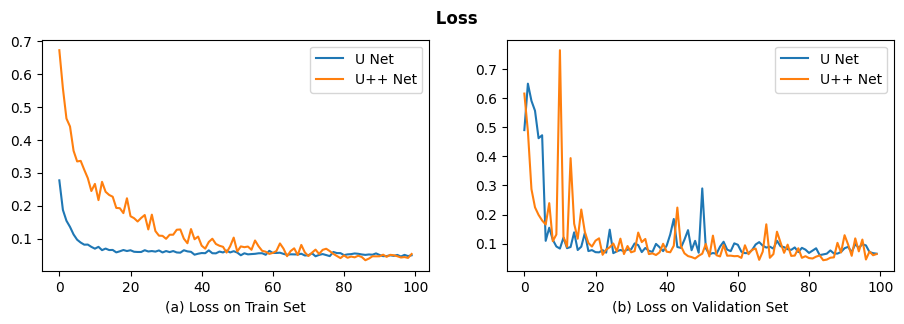

In [11]:
def show_his(u_his, upp_his):
    plt.figure(figsize=(11, 3))
    plt.suptitle(' Loss', fontsize=12, fontweight='bold')
    
    plt.subplot(1, 2, 1)
    plt.plot(u_his.history['loss'], label='U Net')
    plt.plot(upp_his.history['loss'], label='U++ Net')
    plt.legend()
    plt.xlabel('(a) Loss on Train Set', fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(u_his.history['val_loss'], label='U Net')
    plt.plot(upp_his.history['val_loss'], label='U++ Net')
    plt.legend()
    plt.xlabel('(b) Loss on Validation Set', fontsize=10)
    

show_his(u_his=u_his, upp_his=upp_his)

In [12]:
def calculate_iou_score(target, prediction, is_print: bool=False):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    if is_print:
        print('IoU : %f' %iou_score)
    return iou_score

In [13]:
def get_output(model, preproc, image_path: str, label_path: str, is_imshow: bool=False):
    def get_processed(img_path, preproc):
        img = imread(img_path)
        img = {'image': img}
        return preproc(**img)['image']
    
    processed = get_processed(image_path, preproc)
    output = model(np.expand_dims(processed/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1) * 255
    
    origin_img = imread(image_path)
    prediction = output / 255
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    
    label_processed = get_processed(label_path, preproc)
    target = (label_processed==7).astype(np.uint8) * 1
    
    if is_imshow:
        plt.imshow(output)
    return output, prediction, target

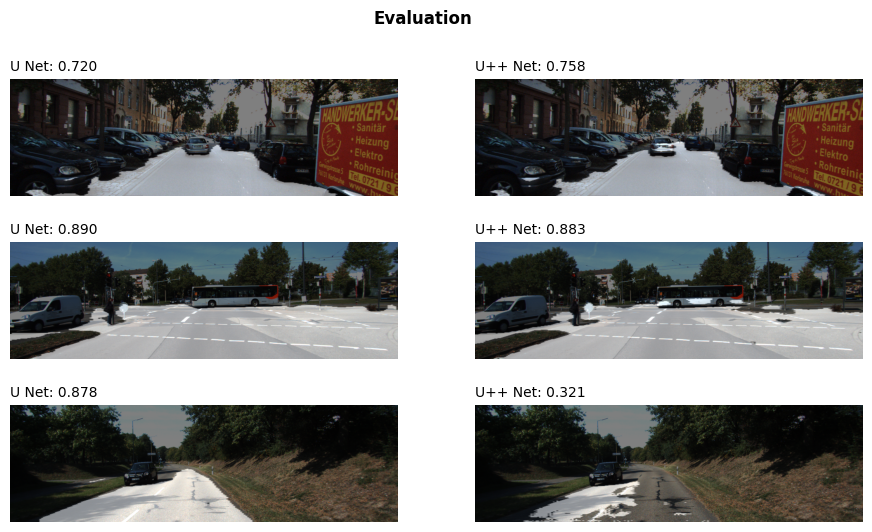

In [14]:
import random

def evaluate(u_model, upp_model, ex_num: int=1, main_path: str='../datasets/gd_08/dataset/training'):
    def get_result(model, x_path, y_path):
        #img와 iou 반환
        output, pred, target = get_output(
            model=model, preproc=test_preproc, image_path=x_path, label_path=y_path, is_imshow=False
        )
        iou = calculate_iou_score(target, pred)
        return output, iou
    
    def imshow(idx, img, txt) -> None:
        write_title = lambda txt: plt.title(txt, fontdict={'fontsize': 10}, loc='left')
        
        plt.subplot(ex_num, 2, idx)
        plt.axis('off')
        plt.imshow(img)
        write_title(txt)
    
    
    sample_files = random.choices(
        os.listdir(main_path + '/image_2'),
        k=ex_num
    )
    
    
    plt.figure(figsize=(11, 2*ex_num))
    plt.suptitle('Evaluation', fontsize=12, fontweight='bold')
    
    for idx, file_name in enumerate(sample_files):
        x_path, y_path = main_path + f'/image_2/{file_name}', main_path + f'/semantic/{file_name}'
        
        u_img, u_iou = get_result(model=u_model, x_path=x_path, y_path=y_path)
        upp_img, upp_iou = get_result(model=upp_model, x_path=x_path, y_path=y_path)
        
        imshow(idx=2*idx+1, img=u_img, txt=f'U Net: {u_iou:.3f}')
        imshow(idx=2*(idx+1), img=upp_img, txt=f'U++ Net: {upp_iou:.3f}')
        

        
evaluate(u_model=u_model, upp_model=upp_model, ex_num=3)

#### 모델 생성 함수 정의
***
+ 모든 네트워크로, `ImageNet`을 사전 학습한 `ResNet-50`을 이용한다.


+ 모든 네트워크는 20회 학습하며, momentum은 0.9, 학습률은 0.001로 초기화하고 6 epoch마다 0.1을 취한다.
***

In [15]:
EPOCH = 20

lr_scheduler = LearningRateScheduler(lambda epoch: 0.001 * 0.1 ** (epoch//6), verbose=0)

#Model address: C:\Users\yagi\.keras\models
def getModel():
    model = K.models.Sequential([
        K.applications.ResNet50V2(
            include_top=False,
            weights='imagenet', #'imagenet'
            input_shape=(224, 224, 3),
            pooling='avg' #'avg'
        ),
        K.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=K.optimizers.SGD(momentum=0.9), 
        metrics=['accuracy']
    )
    return model

<br>

### 4.1. 원본 데이터셋
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 원본 데이터셋을 학습하여 모델을 평가합니다. 배치 사이즈를 32로 설정하여 총 20회 학습하였습니다. 그 결과, 테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 1.0539, 최저는 1.0460입니다. 테스트 데이터셋에 대한 정확도의 경우 최종 Epoch일 때 0.7108, 최고는 0.7118입니다.
   
</span>

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|1.0539|0.7108|
|**Best**|1.0460|0.7118|

***

In [17]:
model = getModel()

his_ori = model.fit(
    ds_train_ori,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[lr_scheduler]
)

Epoch 1/20
375/375 [==============================] - 42s 93ms/step - loss: 2.6140 - accuracy: 0.3918 - val_loss: 1.3179 - val_accuracy: 0.6255
Epoch 2/20
375/375 [==============================] - 34s 90ms/step - loss: 0.8428 - accuracy: 0.7748 - val_loss: 1.1694 - val_accuracy: 0.6607
Epoch 3/20
375/375 [==============================] - 34s 89ms/step - loss: 0.3238 - accuracy: 0.9327 - val_loss: 1.1438 - val_accuracy: 0.6730
Epoch 4/20
375/375 [==============================] - 34s 91ms/step - loss: 0.1368 - accuracy: 0.9841 - val_loss: 1.1224 - val_accuracy: 0.6833
Epoch 5/20
375/375 [==============================] - 34s 91ms/step - loss: 0.0617 - accuracy: 0.9958 - val_loss: 1.1304 - val_accuracy: 0.6824
Epoch 6/20
375/375 [==============================] - 34s 91ms/step - loss: 0.0376 - accuracy: 0.9972 - val_loss: 1.0824 - val_accuracy: 0.6926
Epoch 7/20
375/375 [==============================] - 34s 90ms/step - loss: 0.0268 - accuracy: 0.9991 - val_loss: 1.0460 - val_accuracy:

<br>

### 4.2. 기본 증강 데이터셋
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 기본 증강 데이터셋을 학습하여 모델을 평가합니다. 배치 사이즈를 32로 설정하여 총 20회 학습하였습니다. 그 결과, 테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.9653, 최저는 0.9634입니다. 테스트 데이터셋에 대한 정확도의 경우 최종 Epoch일 때 0.7253, 최고는 0.7267입니다.
   
</span>

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.9653|0.7253|
|**Best**|0.9634|0.7267|

***

In [19]:
model = getModel()

his_aug = model.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[lr_scheduler]
)

Epoch 1/20
375/375 [==============================] - 38s 93ms/step - loss: 2.6747 - accuracy: 0.3864 - val_loss: 1.3908 - val_accuracy: 0.6026
Epoch 2/20
375/375 [==============================] - 45s 120ms/step - loss: 1.0196 - accuracy: 0.7155 - val_loss: 1.1925 - val_accuracy: 0.6556
Epoch 3/20
375/375 [==============================] - 64s 170ms/step - loss: 0.5902 - accuracy: 0.8404 - val_loss: 1.0375 - val_accuracy: 0.7020
Epoch 4/20
375/375 [==============================] - 66s 175ms/step - loss: 0.3535 - accuracy: 0.9146 - val_loss: 1.1338 - val_accuracy: 0.6693
Epoch 5/20
375/375 [==============================] - 66s 177ms/step - loss: 0.2168 - accuracy: 0.9538 - val_loss: 1.0399 - val_accuracy: 0.7104
Epoch 6/20
375/375 [==============================] - 67s 179ms/step - loss: 0.1397 - accuracy: 0.9750 - val_loss: 1.0726 - val_accuracy: 0.6992
Epoch 7/20
375/375 [==============================] - 68s 181ms/step - loss: 0.0897 - accuracy: 0.9869 - val_loss: 0.9814 - val_acc

<br>

### 4.3. Mixup 데이터셋
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Mixup 데이터셋을 학습하여 모델을 평가합니다. 배치 사이즈를 32로 설정하여 총 20회 학습하였습니다. 그 결과, 테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 1.0834, 최저는 1.0804입니다. 테스트 데이터셋에 대한 정확도의 경우 최종 Epoch일 때 가장 높았으며, 0.6905입니다.
   
</span>

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|1.0834|0.6905|
|**Best**|1.0804|0.6905|

***

In [21]:
model = getModel()

his_mixup = model.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[lr_scheduler]
)

Epoch 1/20
375/375 [==============================] - 53s 126ms/step - loss: 4.1869 - accuracy: 0.1532 - val_loss: 2.2337 - val_accuracy: 0.3979
Epoch 2/20
375/375 [==============================] - 46s 123ms/step - loss: 3.2573 - accuracy: 0.3678 - val_loss: 1.7443 - val_accuracy: 0.5333
Epoch 3/20
375/375 [==============================] - 47s 127ms/step - loss: 2.9710 - accuracy: 0.4630 - val_loss: 1.5338 - val_accuracy: 0.5830
Epoch 4/20
375/375 [==============================] - 47s 126ms/step - loss: 2.8111 - accuracy: 0.5093 - val_loss: 1.4289 - val_accuracy: 0.5989
Epoch 5/20
375/375 [==============================] - 47s 127ms/step - loss: 2.7243 - accuracy: 0.5552 - val_loss: 1.4632 - val_accuracy: 0.5975
Epoch 6/20
375/375 [==============================] - 48s 128ms/step - loss: 2.5713 - accuracy: 0.6067 - val_loss: 1.3424 - val_accuracy: 0.6294
Epoch 7/20
375/375 [==============================] - 46s 122ms/step - loss: 2.4449 - accuracy: 0.6562 - val_loss: 1.2017 - val_ac

<br>

### 4.4. Cutmix 데이터셋
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 기본 증강 데이터셋을 학습하여 모델을 평가합니다. 배치 사이즈를 32로 설정하여 총 20회 학습하였습니다. 그 결과, 테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 1.0291, 최저는 1.0236입니다. 테스트 데이터셋에 대한 정확도의 경우 최종 Epoch일 때 0.7094, 최고는 0.7113입니다.
   
</span>

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|1.0291|0.7094|
|**Best**|1.0236|0.7113|

***

In [23]:
model = getModel()

his_cutmix = model.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[lr_scheduler]
)

Epoch 1/20
375/375 [==============================] - 51s 122ms/step - loss: 4.3443 - accuracy: 0.1122 - val_loss: 2.2297 - val_accuracy: 0.4272
Epoch 2/20
375/375 [==============================] - 46s 123ms/step - loss: 3.4324 - accuracy: 0.3125 - val_loss: 1.7140 - val_accuracy: 0.5343
Epoch 3/20
375/375 [==============================] - 52s 138ms/step - loss: 3.1192 - accuracy: 0.3995 - val_loss: 1.5130 - val_accuracy: 0.5774
Epoch 4/20
375/375 [==============================] - 48s 127ms/step - loss: 2.8987 - accuracy: 0.4637 - val_loss: 1.4663 - val_accuracy: 0.5938
Epoch 5/20
375/375 [==============================] - 46s 122ms/step - loss: 2.8087 - accuracy: 0.4955 - val_loss: 1.3568 - val_accuracy: 0.6201
Epoch 6/20
375/375 [==============================] - 46s 123ms/step - loss: 2.7137 - accuracy: 0.5233 - val_loss: 1.3842 - val_accuracy: 0.6215
Epoch 7/20
375/375 [==============================] - 48s 129ms/step - loss: 2.6019 - accuracy: 0.5640 - val_loss: 1.1211 - val_ac

<br>

### 4.4. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 테스트 데이터셋에 대한 각 모델의 손실값을 비교하였습니다. 그 결과, '기본 증강 데이터셋`, 'Cutmix 데이터셋', '원본 데이터셋', 'Mixup 데이터셋' 모델 순으로 성능이 높음을 확인하였습니다. 기본 증강 데이터셋과 Cutmix 데이터셋의 경우 원본 데이터셋을 사용했을 때 보다 성능이 상승하였지만, Mixup 데이터셋의 경우 오히려 성능이 저하됨을 확인하였습니다. Table 1은 테스트 셋에 대한 BEST 손실값입니다. Figure는 테스트 셋에 대한 각 증각 기법의 손실 변화를 시각화 한 것으로, Figure (b)는 편의를 위해 0.9에서 1.4 사이로 제한하여 시각화 한 것입니다.
</span>

<br><br>

<center>Table 1. <b>&lt;TEST 데이터셋에 대한 BEST 손실값></b></center>

||Original|augmentation|Mixup|Cutmix|
|:---:|:---:|:---:|:---:|:---:|
|**Loss**|1.0460(3)|**<span style="color:red">0.9634</span>**(1)|1.0804(4)|**<span style="color:blue">1.0236</span>**(2)|

<br>
    
***

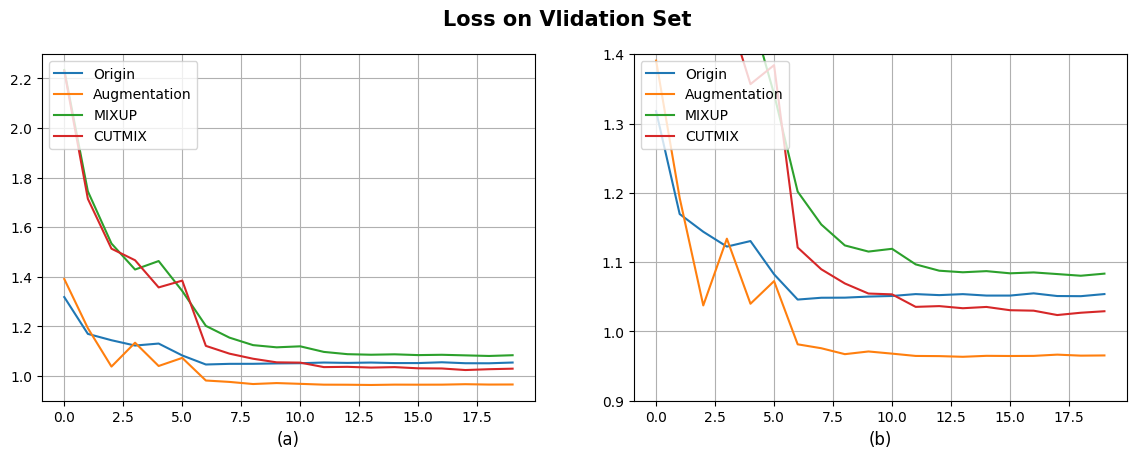

In [2]:
def drawGraph():
    plt.plot(his_ori['val_loss'])
    plt.plot(his_aug['val_loss'])
    plt.plot(his_mixup['val_loss'])
    plt.plot(his_cutmix['val_loss'])
    plt.legend(['Origin', 'Augmentation', 'MIXUP', 'CUTMIX'], loc='upper left')
    plt.grid(True)
    

plt.figure(figsize=(14, 4.5))
plt.suptitle('Loss on Vlidation Set', fontsize=15, fontweight ='bold')

plt.subplot(1, 2, 1)
drawGraph()
plt.xlabel('(a)', fontsize=12)

plt.subplot(1, 2, 2)
drawGraph()
plt.ylim(0.9, 1.40)
plt.xlabel('(b)', fontsize=12)

plt.show()

<br>

## 5. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트에서는 다양한 데이터 증강 기법에 따른 전이학습 성능을 확인하였습니다. 증강 기법으로는 좌우 대칭 회전, 밝기 변화 등을 사용하는 '기본 증강 기법'과 'Mixup', 그리고 'Cutmix'를 사용하였고 Baseline 확인을 위해 원본 데이터셋을 사용하였습니다. 네트워크로 ImageNet을 사전학습한 ResNet-50을 사용하였습니다. 손실값을 근거로 증강 기법에 따른 성능을 확인한 결과, '기본 증강`, 'Cutmix', '원본', 'Mixup' 순으로 손실값이 낮은 것을 확인하였습니다.
</span>

<br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Mixup의 경우에는 오히려 원본 데이터셋을 사용한 경우 보다 성능이 저하되었습니다. 윤상두 외 5인은 'Mixup으로 생성한 데이터가 지역적으로 모호하고 부자연스럽기 때문에 네트워크에 혼란을 준다'고 하였으며 나아가 'Mixup의 새로운 변형들도 전이 학습 성능에서의 심층 분석이 부족한 실정이며, Cutmix는 이미지 분류 문제에 국한하지 않고 광범위한 위치 탐지 및전이 학습 실험에서 이점이 있다'고 하였습니다[1]. 따라서, 동일한 종인 개의 품종을 판단하는 해당 프로젝트에서는 이러한 문제가 더욱 크게 작용하였다고 해석할 수 있습니다.
</span>

***

<br>

### *Reference*

***
[1] Yun, S., Han, D., Oh, S. J., Chun, S., Choe, J., & Yoo, Y. (2019). Cutmix: Regularization strategy to train strong classifiers with localizable features. In Proceedings of the IEEE/CVF international conference on computer vision (pp. 6023-6032).
***

<br>

#### 형상관리 기록
***
+ v1_1: 초기 예제
***